# Train and Evaluate a Linear Model (Week one Assignment)

In [33]:
# Import Libraries
import math
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Explore dataset

In [2]:
df = pd.read_parquet("data/yellow_tripdata_2023-01.parquet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

### Load datasets

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
# Compute trip durations in minutes
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [6]:
# Compute statistics
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
count,3.066766e+06,3066766,3066766,2.995023e+06,3.066766e+06,2.995023e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,2.995023e+06,2.995023e+06,3.066766e+06
mean,1.730215e+00,2023-01-17 00:22:26.288164,2023-01-17 00:38:06.427874,1.362532e+00,3.847342e+00,1.497440e+00,1.663980e+02,1.643926e+02,1.194483e+00,1.836707e+01,1.537842e+00,4.882900e-01,3.367941e+00,5.184907e-01,9.820847e-01,2.702038e+01,2.274231e+00,1.074086e-01,1.566900e+01
min,1.000000e+00,2008-12-31 23:01:42,2009-01-01 14:29:11,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-6.500000e+01,-1.000000e+00,-7.510000e+02,-2.500000e+00,-1.250000e+00,-2.920000e+01
25%,1.000000e+00,2023-01-09 16:21:57.250000,2023-01-09 16:37:06,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.540000e+01,2.500000e+00,0.000000e+00,7.116667e+00
50%,2.000000e+00,2023-01-17 08:42:29.500000,2023-01-17 08:58:30.500000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.720000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00,1.151667e+01
75%,2.000000e+00,2023-01-24 16:26:27,2023-01-24 16:42:49,1.000000e+00,3.330000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00,1.830000e+01
max,2.000000e+00,2023-02-01 00:56:53,2023-02-02 09:28:47,9.000000e+00,2.589281e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.160100e+03,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,1.169400e+03,2.500000e+00,1.250000e+00,1.002918e+04
std,4.438480e-01,NaN,NaN,8.961200e-01,2.495838e+02,6.474767e+00,6.424413e+01,6.994368e+01,5.294762e-01,1.780782e+01,1.789592e+00,1.034641e-01,3.826759e+00,2.017579e+00,1.833529e-01,2.216359e+01,7.718454e-01,3.556511e-01,4.259435e+01


### Features Engineering

In [7]:
# Define categorical variables 
categorical = ["PULocationID", "DOLocationID"]
df[categorical] = df[categorical].astype(str)

In [8]:
# Remove outliers for durations below 1 and above 60 minutes
df_train = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3009173 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [10]:
print(len(df_train) / len(df))

0.9812202822125979


In [11]:
df_train[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [12]:
# turn dictionary into vector
dv = DictVectorizer()

In [13]:
train_dicts = df_train[categorical].to_dict(orient='records')

In [14]:
# Feature matrix
X_train = dv.fit_transform(train_dicts)

In [15]:
# Get dimensionality of feature matrix
X_train.shape

(3009173, 515)

In [16]:
# Target matrix
target = 'duration'
y_train = df_train[target].values

In [17]:
# Get dimensionality of ftarget vector
y_train.shape

(3009173,)

### Build Model

In [18]:
lr = LinearRegression()

In [19]:
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_28239/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/gab_o/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_28239/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level funct

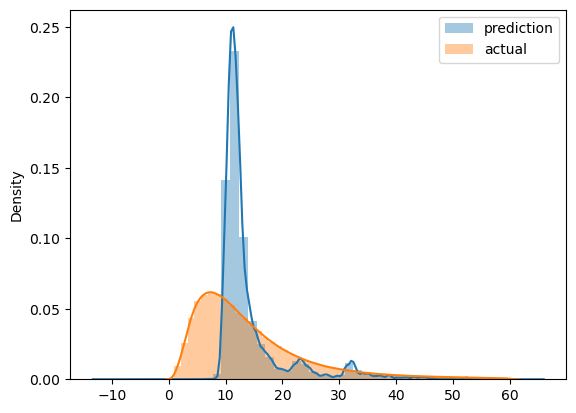

In [21]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [22]:
MSE = mean_squared_error(y_train, y_pred, squared=False)
MSE

7.649261812064437

This means that our model is late by 7 minutes

In [23]:
RMSE = math.sqrt(MSE)
RMSE

2.7657298877628014

### Model Evaluation

In [24]:
# Create a function to apply the same processing to the validation dataset 

def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    # Compute trip durations in minutes
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # Define categorical variables 
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    # Remove outliers for durations below 1 and above 60 minutes
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    return df

In [25]:
df_val = read_dataframe("data/yellow_tripdata_2023-02.parquet")

In [26]:
len(df_train), len(df_val)

(3009173, 2855951)

In [29]:
val_dicts = df_val[categorical].to_dict(orient='records')

# Feature matrix
X_val = dv.transform(val_dicts)

# Target matrix
target = 'duration'
y_val = df_val[target].values

# fit model
# lr.fit(X_val, y_val)

y_pred = lr.predict(X_val)

print(X_val.shape, y_val.shape)

(2855951, 515) (2855951,)


In [30]:
MSE = mean_squared_error(y_val, y_pred, squared=False)
MSE

7.811822042099508

In [31]:
RMSE = math.sqrt(MSE)
RMSE

2.794963692447454

In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)